In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from segmentflow import segment, view
from skimage import measure
%load_ext autoreload
%autoreload 2

Developed from mhe-analysis NB 36

In [3]:
def get_dims_df(imgs_labeled):
    # Format segmented data
    dims_df = pd.DataFrame(measure.regionprops_table(
        imgs_labeled, properties=['label', 'area', 'bbox']))
    dims_df = dims_df.rename(columns={'area' : 'volume'})
    # Calculate nslices by subtracting z min from max
    dims_df['nslices'] = (
        dims_df['bbox-3'].to_numpy() - dims_df['bbox-0'].to_numpy())
    # Calculate nrows by subtracting y min from max
    dims_df['nrows'] = (
        dims_df['bbox-4'].to_numpy() - dims_df['bbox-1'].to_numpy())
    # Calculate ncols by subtracting x min from max
    dims_df['ncols'] = (
        dims_df['bbox-5'].to_numpy() - dims_df['bbox-2'].to_numpy())
    return dims_df

def simulate_sieve(dims_df, bin_edges, pixel_res):
    # Define dimensions a, b, c with a as largest and c as smallest
    dims_df['a'] = dims_df.apply(
        lambda row: row['nslices' : 'ncols'].astype(int).nlargest(3).iloc[0],
        axis=1
    )
    dims_df['b'] = dims_df.apply(
        lambda row: row['nslices' : 'ncols'].astype(int).nlargest(3).iloc[1],
        axis=1
    )
    dims_df['c'] = dims_df.apply(
        lambda row: row['nslices' : 'ncols'].astype(int).nlargest(3).iloc[2],
        axis=1
    )
    # Apply pixel resolution to second smallest dimension
    b_ums = pixel_res * dims_df['b'].to_numpy()
    n_particles, sieve_sizes = np.histogram(b_ums, bins=bin_edges)
    return n_particles, sieve_sizes

def grading_curve(
    n_particles, sieve_sizes, standard_pct=None, standard_label='Standard'
):
    n_particles = np.insert(n_particles, 0, 0)
    pct_particles = 100 * n_particles / np.sum(n_particles)
    # Plot histogram
    plt.rcParams["font.family"] = "monospace"
    fig, ax = plt.subplots(
        figsize=(8, 5), facecolor='white', constrained_layout=True, dpi=300)
    ax.scatter(sieve_sizes, np.cumsum(pct_particles), s=10, zorder=2)
    ax.plot(
        sieve_sizes, np.cumsum(pct_particles), label='Segmented',
        linewidth=1, zorder=2
    )
    if standard_pct is not None:
        standard_pct = np.insert(standard_pct, 0, 0)
        ax.scatter(sieve_sizes, standard_pct, s=10, zorder=2)
        ax.plot(
            sieve_sizes, standard_pct, label=standard_label,
            linewidth=1, zorder=2
        )
    ax.set_title('Segmented Particle Size Distribution by Aspect Ratio')
    ax.set_ylabel(r'Retained (%)')
    ax.set_ylim([0, 111])
    ax.set_xlabel('Particle diameter ($\mu m$)')
    ax.grid(True, axis='y', zorder=0)
    ax.set_xticks(sieve_sizes)
    ax.set_xticklabels(sieve_sizes)
    ax.legend(loc='lower right', ncol=1)
    return fig, ax

## Plot STL-0 Size Distribution

In [4]:
csv_path = Path(
    r'C:\Users\cgusb\Research\PSAAP\alshibli_1551_study'
    r'\alshibli-1551-bounds.csv')
dims_df = pd.read_csv(csv_path)
dims_df.head()

,x_min,y_min,z_min,x_max,y_max,z_max,filename,nslices,nrows,ncols
0,1100.626221,1962.473877,9.454297,1232.025391,2083.570557,155.095642,P1,145.641345,121.096680,131.399170
1,1947.992554,2183.382324,14.656619,2126.827637,2369.646973,213.044571,P10,198.387952,186.264648,178.835083
2,3086.012695,1167.215088,143.818481,3366.259766,1419.653809,463.213501,P100,319.395020,252.438721,280.247070
3,25.117933,1877.562256,1378.579712,299.455719,2205.922119,1712.898682,P1000,334.318970,328.359863,274.337786
4,2468.705322,1687.952271,1382.988037,2758.225830,1947.786255,1566.749023,P1001,183.760986,259.833984,289.520508


stl0_cum_pct=array([  1.16054159,   4.12637008,  13.34622824,  33.52675693,
        65.95744681,  96.77627337, 100.        , 100.        ])


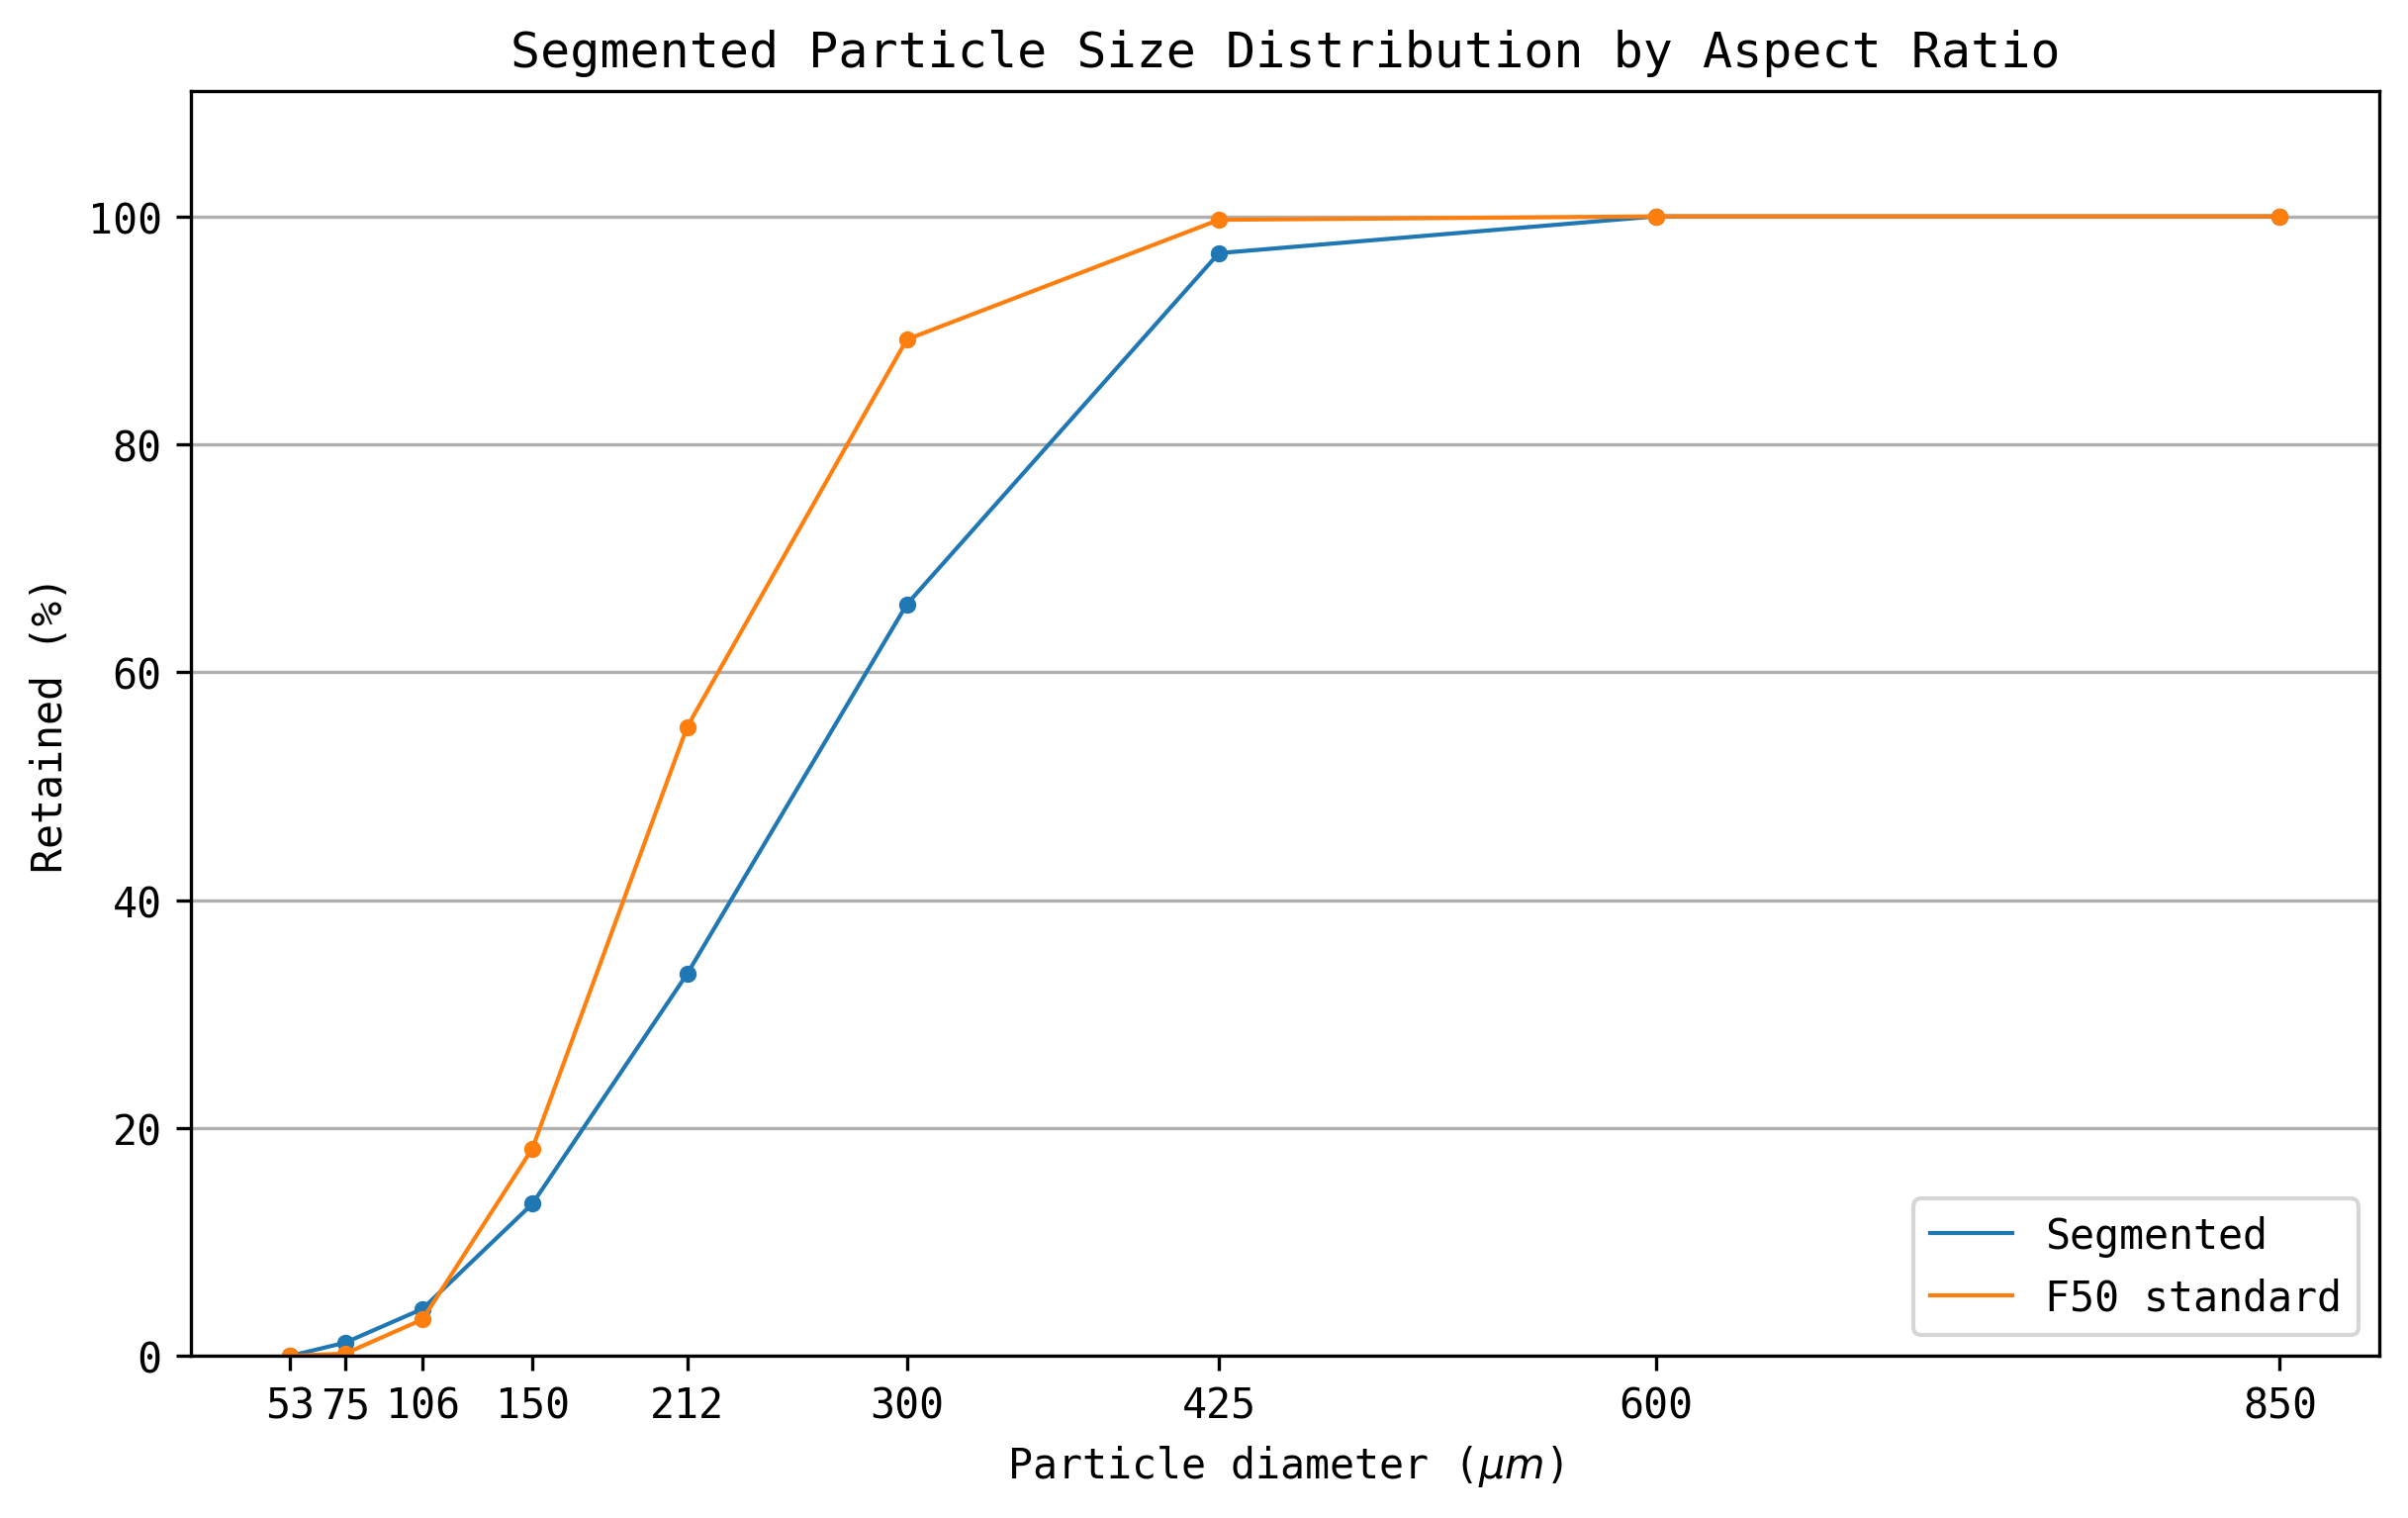

In [5]:
f50_bin_edges = [53,  75, 106, 150, 212, 300,  425, 600, 850]
f50_standard =  [0.2,   3,  15,  37,  34, 10.5, 0.3,   0]
# ct_res = 2.02  # ums/voxels
csv_path = Path(
    r'C:\Users\cgusb\Research\PSAAP\alshibli_1551_study'
    r'\alshibli-1551-bounds.csv')
dims_df = pd.read_csv(csv_path)
stl0_n_particles, sieve_sizes = simulate_sieve(
    dims_df, f50_bin_edges, pixel_res=1)
fig, ax = grading_curve(
    stl0_n_particles, f50_bin_edges, standard_pct=np.cumsum(f50_standard),
    standard_label='F50 standard')
stl0_pct_particles = 100 * stl0_n_particles / np.sum(stl0_n_particles)
stl0_cum_pct = np.cumsum(stl0_pct_particles)
print(f'{stl0_cum_pct=}')
plt.show()

In [11]:
n_particles_df = pd.DataFrame(columns=['bin min', 'bin max', 'n particles'])
n_particles_df['bin min'] = np.insert(f50_bin_edges[0:-1], 0, 0)
n_particles_df['bin max'] = np.insert(f50_bin_edges[1:], 0, f50_bin_edges[0])
n_particles_df['n particles'] = np.insert(f50_standard, 0, 0)
n_particles_df

,bin min,bin max,n particles
0,0,53,0.0
1,53,75,0.2
2,75,106,3.0
3,106,150,15.0
4,150,212,37.0
5,212,300,34.0
6,300,425,10.5
7,425,600,0.3
8,600,850,0.0
